In [1]:
%pylab inline
from astropy.cosmology import Planck13
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildQSOspectra

Populating the interactive namespace from numpy and matplotlib


In [2]:
# cover 3000A to 5um at R=4000
wave = sqbase.fixed_R_dispersion(3000,5e4,4000)

(-24.75, -27.25)

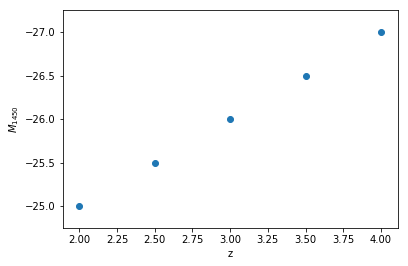

In [3]:
# just make up a few magnitude and redshift points
nqso = 5
M = AbsMagVar(FixedSampler(linspace(-27,-25,nqso)[::-1]),restWave=1450)
z = RedshiftVar(FixedSampler(linspace(2,4,nqso)))
qsos = QsoSimPoints([M,z],cosmo=Planck13,units='luminosity')
scatter(qsos.z,qsos.absMag)
xlabel('z')
ylabel('$M_{1450}$')
ylim(-24.75,-27.25)

In [4]:
# use the canonical values for power law continuum slopes in FUV/NUV, with breakpoint at 1215A
#  (not really valid at long wavelengths but just to show a simple example)
contVar = BrokenPowerLawContinuumVar([GaussianSampler(-1.5,0.3),
                                      GaussianSampler(-0.5,0.3)],
                                     [1215.])

In [5]:
# generate lines using the Baldwin Effect emission line model from BOSS DR9
emLineVar = generateBEffEmissionLines(qsos.absMag)

In [6]:
# the default iron template from Vestergaard & Wilkes 2001 was modified to fit BOSS spectra
fescales = [(0,1540,0.5),(1540,1680,2.0),(1680,1868,1.6),(1868,2140,1.0),(2140,3500,1.0)]
feVar = FeTemplateVar(VW01FeTemplateGrid(qsos.z,wave,scales=fescales))

using Fe scales:  [(0, 1540, 0.5), (1540, 1680, 2.0), (1680, 1868, 1.6), (1868, 2140, 1.0), (2140, 3500, 1.0)]


In [7]:
# Now add the features to the QSO grid
qsos.addVars([contVar,emLineVar,feVar])

In [8]:
# ready to generate spectra
_,spectra = buildQSOspectra(wave,qsos,saveSpectra=True)

units are  luminosity
buildQSOspectra iteration  1  out of  1


In [9]:
qsos.data

absMag,z,slopes [2],"emLines [62,3]"
float64,float64,float64,float64
-25.0,2.0,-1.95261717662 .. -0.355779637192,1033.08105039 .. 291.26862884
-25.5,2.5,-1.89286042279 .. -0.513984292765,1033.00193309 .. 308.249434695
-26.0,3.0,-1.25503675248 .. -0.238938211039,1034.30562951 .. 345.117802732
-26.5,3.5,-1.23529467612 .. -0.315412278395,1033.51803123 .. 273.322765243
-27.0,4.0,-1.19931456156 .. -0.465597459837,1033.86210928 .. 302.654846748


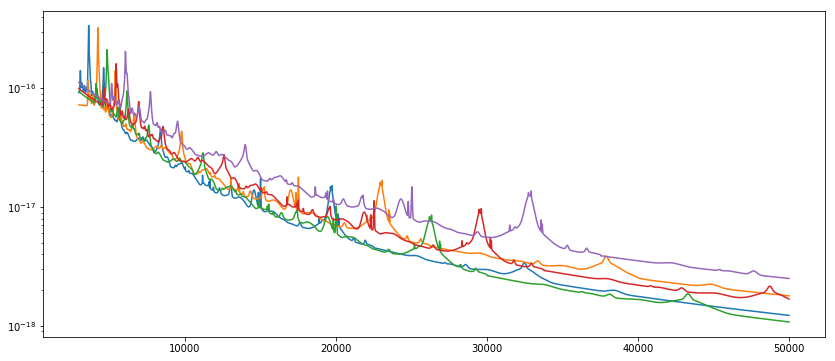

In [10]:
figure(figsize=(14,6))
for sp in spectra:
    plot(wave,sp)
yscale('log')

(3000, 7000)

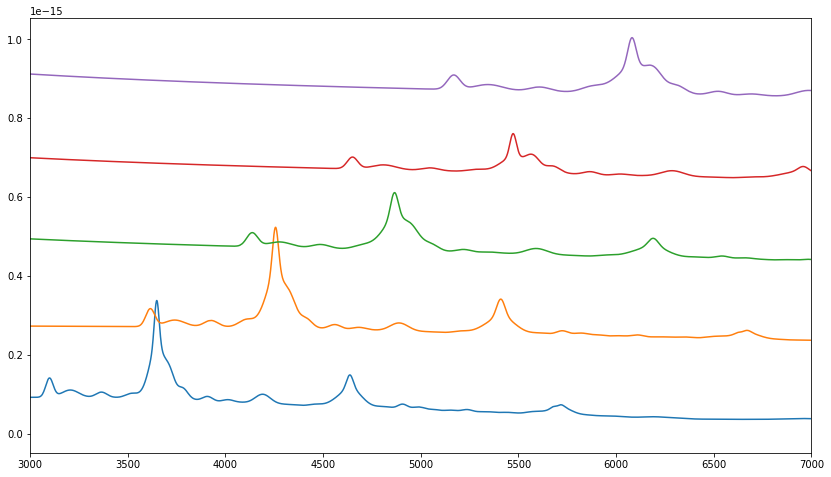

In [11]:
figure(figsize=(14,8))
for i,sp in enumerate(spectra):
    plot(wave,sp+i*2e-16)
xlim(3000,7000)